### What is archived data?

These are the data going back to Spring 2017 (period 597). 

The leaderboards for those weeks are in their final state. I would like to pull these data into the DB. This only has to be done once.

In [117]:
import requests
import importlib
import blizzard_api
import mysql
import mplusdb
import blizzard_credentials
import pandas as pd
import utils
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [111]:
auth = blizzard_credentials.Credentials('.api_tokens')
access_token = auth.access_token

In [114]:
url_factory = blizzard_api.UrlFactory(access_token = access_token, region='eu')

realm = 1403
urls = []
for dungeon in list(range(244,252+1)) + [353]:
    for period in range(660, 760):
        url = url_factory.get_mythic_plus_leaderboard_url(dungeon, realm, period)
        urls.append(url)

In [115]:
len(urls)

1000

In [64]:
t0 = time.time()
cut = 100
for index, url in enumerate(urls[:cut]):
    response = requests.get(url)
    if response.status_code != 200:
        print(url)
    print('\rcall %s' % (index+1), end='')
    
print('')
t_end = time.time() - t0
print('time, min: %1.2f' % (t_end/60))
print('time/call: %1.2f' % (t_end/cut))

call 100
time, min: 4.05
time/call: 2.43


In [56]:
def test_function(url):
    time.sleep(0.1)
    response = requests.get(url)
    return response

def test_caller(caller):
    return(id(caller.access_token))


caller_ = blizzard_api.Caller()


urls_ = urls#[:200]
def runner():
    threads = []
    with ThreadPoolExecutor(max_workers = 5) as executor:
        for url in urls_:
            #threads.append(executor.submit(test_caller, caller_))
            threads.append(executor.submit(test_function, url))
    for task in as_completed(threads):
        if task.result().status_code != 200:
            print(task.result().status_code)
        #print(task.__dict__)
        #print(task.result())
        
        
t0 = time.time()        
runner()
print('')
t_end = time.time() - t0
print('time, min: %1.2f' % (t_end/60))
print('time/call, sec: %1.2f' % (t_end/len(urls_)))


time, min: 7.00
time/call, sec: 0.42


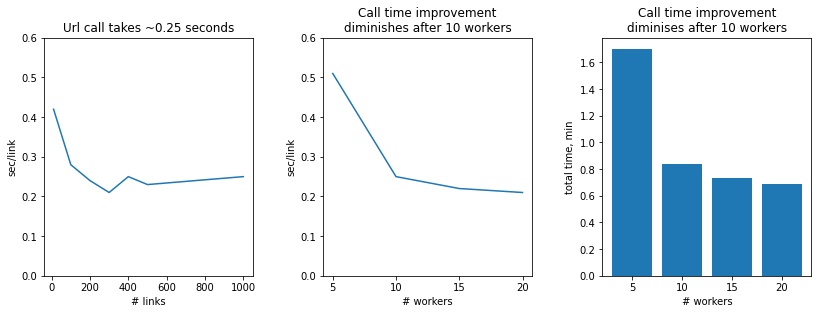

In [123]:
# recorded these by hand. (lazy to write a function)

# with 10 workers
data = {
    'link_num' : [10, 100, 200, 300, 400, 500, 1000],
    'total_time_min' : [0.07, 0.47, 0.82, 1.03, 1.65, 2.03, 4.14],
    'time_per_link_sec' : [0.42, 0.28, 0.24, 0.21, 0.25, 0.23, 0.25]
    }

# with 200 links
# 20 workers run both CPUs at 65% - need to stay <20%
# 10 workers peak at 50%, avg around 30%
data_workers = {
    'num_workers' : [5, 10, 15, 20],
    'total_time_min' : [1.70, 0.84, 0.73, 0.69],
    'time_per_link_sec' : [0.51, 0.25, 0.22, 0.21]
}

performance = pd.DataFrame(data)
thread_performance = pd.DataFrame(data_workers)


fig, axes = plt.subplots(1, 3, figsize = [12, 5])
axes[0].plot(performance.link_num,
    performance.time_per_link_sec)
axes[0].set_title('Url call takes ~0.25 seconds')
axes[0].set(xlabel = '# links')
axes[0].set(ylabel = 'sec/link')
axes[0].set(ylim = [0, 0.6])

axes[1].set_title('fds')
axes[1].plot(thread_performance.num_workers,
    thread_performance.time_per_link_sec)
axes[1].set(ylabel = 'sec/link')
axes[1].set(xlabel = '# workers')
axes[1].set(title = 'Call time improvement\ndiminishes after 10 workers')
axes[1].set(ylim = [0, 0.6])



axes[2].bar([1,2,3,4],
    thread_performance.total_time_min)
axes[2].set(title='Call time improvement\ndiminises after 10 workers')
axes[2].set(ylabel = 'total time, min')
axes[2].set(xlabel = '# workers')
axes[2].xaxis.set_major_locator(ticker.FixedLocator([1,2,3,4]))
axes[2].xaxis.set_major_formatter(ticker.FixedFormatter(['5', '10', '15', '20']))

fig.tight_layout(pad=3)

plt.show()